# Lab 4: Image Segmentation and Object Detection

This lab covers the fundamentals of image segmentation and object detection, from traditional methods to modern deep learning approaches.

## Learning Objectives

Note from Charity: PLEASE use google to help you if you need. The point is to understand, not to test.

By the end of this lab, you will understand:
- The differences between image classification, object detection, instance segmentation, and semantic segmentation
- Some information about image segmentation
- Tools for image annotation and label generation
- Traditional segmentation methods
   - Thresholding, Histograms, Edge detection, watershed, Region-based segmentation, atlas-based, Clustering-based segmentation

In [5]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import filters, measure, morphology, segmentation
from skimage.feature import peak_local_max
from scipy import ndimage
import SimpleITK as sitk

# For visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## What is image segmentation?
Ans: using various techniques/algorithms/functions to annotate individual pixels as belonging to a specific class or instance

*Q: how are "Classic" image segmentation techniques different than deep learning segmentation techniques?*
Ans: 
- Classic image segmentation determine annotations by analyzing inherent qualities of each pixel (called “heuristics”) like color and intensity.
- use neural networks or other models to determine which pixels have which annotations

*what is a model? => this is best explained like: for example a decision tree is a model. A neural network is a model. You cna think of it as a set of rules/patterns that decide a decision. In our case, an example decision can be: "should the pixel be annotated as part of a human lung or empty space?"

How is image segmentation different than:

a) image classification?
- Ans: applies a class- aka a label- to an entire image. Image segmentation is on each pixel.
 
b) object detection?
- Ans: combines image classification with localization of the class inside the image -> generates bounding boxes

# After answering the above, please read the below:

There are two types of image segmentation:
- one type just labels each pixel in the image as a "class"
   - ie: labels a group of pixel as "dog"
- one type not only labels each pixel as a class, but also diffrentiates 
   - ie: labels a group of pixels as "dog #1" and "dog #2". Basically = can seperate multiple instances of the same thing. 

Image segmentation is usually used for one of three things:
1. semantic segmentation
2. instance segmentation
3. panoptic segmentation

The difference between the above 3 tasks is based on how they treat certain types of classes. In Computer Vision, there are TWO types of labels you usually try to label.
1. "Things": Labels that are countable
     ie: car, tree, face.
2. "Stuff": Labels that are highly variable in size, and difficult to count. 
     ie: sand, sky, water, grass <-- for example: one blade of grass is "grass" and so is a field of grass


You don't have to memorize this but:
1. semantic segmentation just tries to label everything as "stuff"
2. instance segmentation tries to separate "things" from "stuff", but does not label "stuff"
3. panoptic segmentation labels both "things" and "stuff"
    - ie: in example below, semantic labels all the cars as "car" but panoptic labels each car individually.

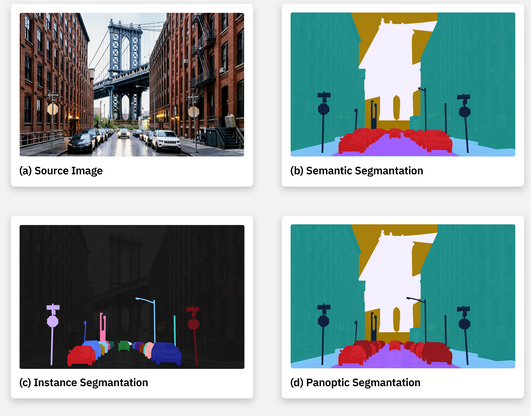

The above information was paraphrased heavily referencing an IBM article. [Full article link](https://www.ibm.com/think/topics/image-segmentation)

## 1. Object Detection vs Instance Segmentation vs Semantic Segmentation

Let's start by understanding the key differences between these three computer vision tasks:

### Object Detection
- **Goal**: Locate and classify objects in images
- **Output**: Bounding boxes + class labels
- **Example**: "There are 3 cars at positions (x1,y1,w1,h1), (x2,y2,w2,h2), (x3,y3,w3,h3)"

### Semantic Segmentation
- **Goal**: Classify every pixel in the image
- **Output**: Pixel-wise class labels (same class = same label)
- **Example**: All car pixels are labeled as "car", but individual cars are not distinguished

### Instance Segmentation
- **Goal**: Classify every pixel AND distinguish between instances
- **Output**: Pixel-wise labels + instance IDs
- **Example**: Car 1 pixels, Car 2 pixels, Car 3 pixels (each car gets unique ID)

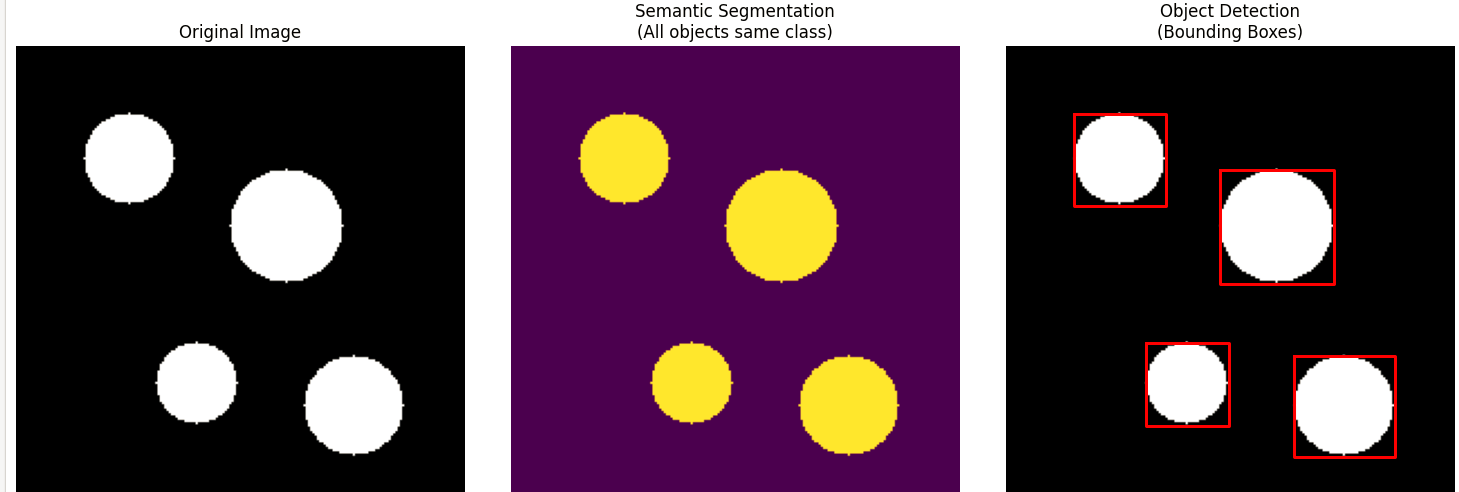


## 2. Image Annotation Tools

Before we can train machine learning models, we need labeled data. Here are popular tools for creating annotations:

### Free/Open Source Tools:
1. **LabelMe** - Web-based annotation tool
2. **CVAT (Computer Vision Annotation Tool)** - Intel's annotation platform
3. **VGG Image Annotator (VIA)** - Lightweight web-based tool
4. **Labelbox** - Has free tier
5. **COCO Annotator** - For COCO format datasets

### Commercial Tools:
1. **Supervisely**
2. **V7 Darwin**
3. **Scale AI**
4. **Amazon SageMaker Ground Truth**

### Medical Imaging Specific:
1. **3D Slicer** - Free, powerful for 3D medical images
2. **ITK-SNAP** - Free, good for 3D segmentation
3. **MITK** - Research platform with annotation capabilities

In [18]:
# Demonstrate annotation format examples
print("=== Common Annotation Formats ===\n")

print("1. COCO Format (Object Detection):")
coco_example = {
    "id": 1,
    "image_id": 123,
    "category_id": 1,
    "bbox": [x, y, width, height],  # [10, 10, 50, 50]
    "area": 2500,
    "iscrowd": 0
}
print(coco_example)

print("\n2. YOLO Format (Object Detection):")
print("class_id x_center y_center width height (normalized 0-1)")
print("0 0.5 0.5 0.2 0.3")

print("\n3. Semantic Segmentation:")
print("- Each pixel has a class label (0=background, 1=car, 2=person, etc.)")
print("- Stored as grayscale images where pixel values = class IDs")

print("\n4. Instance Segmentation:")
print("- Each pixel has instance ID (0=background, 1=car1, 2=car2, 3=person1, etc.)")
print("- Or separate binary masks for each instance")

=== Common Annotation Formats ===

1. COCO Format (Object Detection):


NameError: name 'width' is not defined

## 3. Traditional Segmentation Methods

Before deep learning, computer vision relied on traditional image processing techniques. Let's explore three fundamental approaches:

### 3.1 Atlas-Based Segmentation
Uses a reference template (atlas) to segment new images by registration and label transfer.

https://www.youtube.com/watch?v=rIkhP_oJErw 


In [ ]:
# Atlas-based segmentation example
print("=== Atlas-Based Segmentation ===")
print("This method involves:")
print("1. Register (align) the new image to an atlas image")
print("2. Transfer the atlas labels to the new image")
print("3. Refine the segmentation")

# Simple demonstration with template matching
def atlas_based_demo(image):
    """Simplified atlas-based segmentation demo"""
    # Create a simple "atlas" template
    template = np.zeros((40, 40), dtype=np.uint8)
    cv2.circle(template, (20, 20), 15, 255, -1)
    
    # Template matching (simplified registration)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    
    # Find locations where template matches well
    threshold = 0.3
    locations = np.where(result >= threshold)
    
    # Create segmentation mask
    mask = np.zeros_like(image)
    for pt in zip(*locations[::-1]):
        cv2.circle(mask, (pt[0] + 20, pt[1] + 20), 15, 255, -1)
    
    return mask, result

if 'image' in locals():
    atlas_mask, match_result = atlas_based_demo(image)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(match_result, cmap='hot')
    plt.title('Template Matching Result')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(atlas_mask, cmap='viridis')
    plt.title('Atlas-Based Segmentation')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### 3.2 Thresholding-Based Segmentation
Separates objects from background based on intensity values.

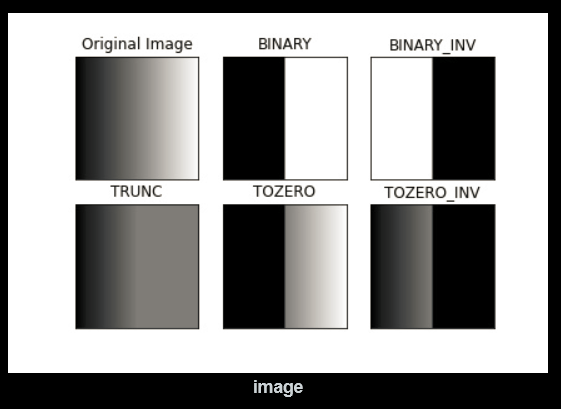


In [ ]:
# Thresholding-based segmentation
print("=== Thresholding-Based Segmentation ===")

if 'image' in locals():
    plt.figure(figsize=(20, 10))
    
    # 1. Simple thresholding
    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # 2. Histogram to choose threshold
    plt.subplot(2, 4, 2)
    plt.hist(image.flatten(), bins=50, alpha=0.7)
    plt.title('Intensity Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    
    # 3. Manual threshold
    manual_thresh = 127
    _, binary_manual = cv2.threshold(image, manual_thresh, 255, cv2.THRESH_BINARY)
    plt.subplot(2, 4, 3)
    plt.imshow(binary_manual, cmap='gray')
    plt.title(f'Manual Threshold ({manual_thresh})')
    plt.axis('off')
    
    # 4. Otsu's automatic thresholding
    otsu_thresh, binary_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.subplot(2, 4, 4)
    plt.imshow(binary_otsu, cmap='gray')
    plt.title(f'Otsu Threshold ({otsu_thresh:.1f})')
    plt.axis('off')
    
    # 5. Adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
    plt.subplot(2, 4, 5)
    plt.imshow(adaptive_thresh, cmap='gray')
    plt.title('Adaptive Threshold')
    plt.axis('off')
    
    # 6. Multi-level thresholding (using skimage)
    thresholds = filters.threshold_multiotsu(image, classes=3)
    regions = np.digitize(image, bins=thresholds)
    plt.subplot(2, 4, 6)
    plt.imshow(regions, cmap='viridis')
    plt.title('Multi-Otsu (3 classes)')
    plt.axis('off')
    
    # 7. Morphological operations to clean up
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    plt.subplot(2, 4, 7)
    plt.imshow(cleaned, cmap='gray')
    plt.title('Morphologically Cleaned')
    plt.axis('off')
    
    # 8. Connected components
    num_labels, labels = cv2.connectedComponents(cleaned)
    plt.subplot(2, 4, 8)
    plt.imshow(labels, cmap='tab20')
    plt.title(f'Connected Components ({num_labels-1})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Otsu threshold: {otsu_thresh:.1f}")
    print(f"Multi-Otsu thresholds: {thresholds}")
    print(f"Number of connected components: {num_labels-1}")

### 3.3 Watershed-Based Segmentation
Treats the image as a topographic map and finds watershed lines to separate objects.

In [ ]:
# Watershed segmentation
print("=== Watershed Segmentation ===")

if 'image' in locals():
    plt.figure(figsize=(20, 10))
    
    # 1. Original image
    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # 2. Distance transform
    binary = (image > filters.threshold_otsu(image)).astype(np.uint8)
    distance = ndi.distance_transform_edt(binary)
    plt.subplot(2, 4, 2)
    plt.imshow(distance, cmap='hot')
    plt.title('Distance Transform')
    plt.colorbar()
    plt.axis('off')
    
    # 3. Find local maxima (seeds)
    local_maxima = peak_local_max(distance, min_distance=20, threshold_abs=0.3*distance.max())
    seeds = np.zeros_like(distance, dtype=bool)
    seeds[tuple(local_maxima.T)] = True
    
    plt.subplot(2, 4, 3)
    plt.imshow(image, cmap='gray')
    plt.plot(local_maxima[:, 1], local_maxima[:, 0], 'r*', markersize=10)
    plt.title('Detected Seeds')
    plt.axis('off')
    
    # 4. Label seeds
    markers, _ = ndi.label(seeds)
    
    plt.subplot(2, 4, 4)
    plt.imshow(markers, cmap='tab20')
    plt.title('Labeled Seeds')
    plt.axis('off')
    
    # 5. Watershed segmentation
    labels = segmentation.watershed(-distance, markers, mask=binary)
    
    plt.subplot(2, 4, 5)
    plt.imshow(labels, cmap='tab20')
    plt.title('Watershed Segmentation')
    plt.axis('off')
    
    # 6. Watershed boundaries
    plt.subplot(2, 4, 6)
    plt.imshow(image, cmap='gray')
    plt.contour(labels, levels=np.unique(labels), colors='red', linewidths=1)
    plt.title('Watershed Boundaries')
    plt.axis('off')
    
    # 7. Alternative: Marker-controlled watershed
    # Create markers from morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary*255, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    plt.subplot(2, 4, 7)
    plt.imshow(sure_fg, cmap='gray')
    plt.title('Sure Foreground')
    plt.axis('off')
    
    # Apply watershed
    _, markers2 = cv2.connectedComponents(sure_fg)
    markers2 = markers2 + 1
    markers2[unknown == 255] = 0
    
    # Convert image to 3-channel for watershed
    img_3ch = cv2.cvtColor((image).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    markers2 = cv2.watershed(img_3ch, markers2)
    img_3ch[markers2 == -1] = [255, 0, 0]  # Mark boundaries in red
    
    plt.subplot(2, 4, 8)
    plt.imshow(cv2.cvtColor(img_3ch, cv2.COLOR_BGR2RGB))
    plt.title('OpenCV Watershed')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Number of watershed regions: {len(np.unique(labels)) - 1}")
    print(f"Seeds found: {len(local_maxima)}")

## 4. Segmentation with Deep Learning

Modern deep learning approaches have revolutionized image segmentation. Let's explore the key architectures and concepts:

### Popular Deep Learning Architectures:

1. **U-Net** - Most popular for medical imaging
2. **FCN (Fully Convolutional Networks)** - Pioneer in semantic segmentation
3. **DeepLab** - Uses atrous convolution for multi-scale features
4. **Mask R-CNN** - Extends Faster R-CNN for instance segmentation
5. **YOLO + segmentation heads** - Real-time segmentation

In [ ]:
# Deep Learning Segmentation Concepts
print("=== Deep Learning Segmentation Overview ===\n")

print("1. U-Net Architecture:")
print("   - Encoder-Decoder structure with skip connections")
print("   - Contracting path (downsampling) + Expansive path (upsampling)")
print("   - Skip connections preserve fine details")
print("   - Originally designed for medical image segmentation")

print("\n2. Key Components:")
print("   - Convolutional layers for feature extraction")
print("   - Pooling layers for downsampling")
print("   - Transpose convolutions for upsampling")
print("   - Skip connections to combine features at different scales")

print("\n3. Loss Functions:")
print("   - Cross-entropy loss (standard)")
print("   - Dice loss (overlap-based)")
print("   - Focal loss (handles class imbalance)")
print("   - Combined losses (e.g., Dice + Cross-entropy)")

print("\n4. Data Augmentation:")
print("   - Rotation, flipping, scaling")
print("   - Elastic deformations")
print("   - Intensity augmentations")
print("   - Cutout/mixup techniques")

In [ ]:
# Simulate a simple deep learning preprocessing pipeline
import torch
import torch.nn.functional as F

def preprocess_for_deep_learning(image, target_size=(256, 256)):
    """
    Preprocessing steps typically used for deep learning segmentation
    """
    # 1. Resize to standard size
    resized = cv2.resize(image, target_size)
    
    # 2. Normalize to [0, 1]
    normalized = resized.astype(np.float32) / 255.0
    
    # 3. Standardize (subtract mean, divide by std)
    # Using ImageNet statistics as example
    mean = 0.485  # For grayscale, use single value
    std = 0.229
    standardized = (normalized - mean) / std
    
    # 4. Convert to tensor and add batch/channel dimensions
    tensor = torch.from_numpy(standardized).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    
    return tensor, normalized

if 'image' in locals():
    # Demonstrate preprocessing
    processed_tensor, normalized_img = preprocess_for_deep_learning(image)
    
    print("Preprocessing Results:")
    print(f"Original shape: {image.shape}")
    print(f"Tensor shape: {processed_tensor.shape}")
    print(f"Tensor dtype: {processed_tensor.dtype}")
    print(f"Tensor range: [{processed_tensor.min():.3f}, {processed_tensor.max():.3f}]")
    
    # Visualize preprocessing steps
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original ({image.shape})')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(normalized_img, cmap='gray')
    plt.title('Normalized [0,1]')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(processed_tensor.squeeze().numpy(), cmap='gray')
    plt.title('Standardized')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Post-processing techniques for deep learning outputs
def postprocess_segmentation(prediction, original_size, threshold=0.5):
    """
    Common post-processing steps for segmentation outputs
    """
    # 1. Apply threshold (for binary segmentation)
    if prediction.max() <= 1.0:  # Probability output
        binary = (prediction > threshold).astype(np.uint8)
    else:  # Already binary
        binary = prediction.astype(np.uint8)
    
    # 2. Remove small objects
    cleaned = morphology.remove_small_objects(binary.astype(bool), min_size=50)
    
    # 3. Fill holes
    filled = ndi.binary_fill_holes(cleaned)
    
    # 4. Resize back to original size
    resized = cv2.resize(filled.astype(np.uint8), original_size[::-1])
    
    # 5. Connected component analysis
    num_labels, labels = cv2.connectedComponents(resized)
    
    return resized, labels, num_labels-1

# Example usage with our thresholded image
if 'binary_otsu' in locals():
    # Simulate a "prediction" by adding some noise and resizing
    noisy_pred = binary_otsu.astype(np.float32) / 255.0
    noisy_pred += np.random.normal(0, 0.1, noisy_pred.shape)
    noisy_pred = np.clip(noisy_pred, 0, 1)
    
    # Resize to simulate model output size
    small_pred = cv2.resize(noisy_pred, (128, 128))
    
    # Post-process
    final_mask, labeled_components, num_objects = postprocess_segmentation(
        small_pred, image.shape
    )
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(noisy_pred, cmap='gray')
    plt.title('Simulated Raw Prediction')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(small_pred, cmap='gray')
    plt.title('Resized Prediction')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Post-processed Mask')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_components, cmap='tab20')
    plt.title(f'Final Components ({num_objects})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detected {num_objects} objects after post-processing")

## 5. Evaluation Metrics for Segmentation

Understanding how to evaluate segmentation performance is crucial:

### Common Metrics:
1. **Pixel Accuracy** - Percentage of correctly classified pixels
2. **IoU (Intersection over Union)** - Overlap between prediction and ground truth
3. **Dice Coefficient** - 2 * |A ∩ B| / (|A| + |B|)
4. **Hausdorff Distance** - Maximum distance between boundaries
5. **Mean Average Precision (mAP)** - For object detection/instance segmentation

In [ ]:
# Segmentation evaluation metrics
def calculate_segmentation_metrics(pred_mask, true_mask):
    """
    Calculate common segmentation metrics
    """
    # Ensure binary masks
    pred_bin = (pred_mask > 0).astype(bool)
    true_bin = (true_mask > 0).astype(bool)
    
    # Intersection and union
    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()
    
    # Metrics
    pixel_accuracy = np.mean(pred_bin == true_bin)
    
    iou = intersection / union if union > 0 else 0
    
    dice = (2 * intersection) / (pred_bin.sum() + true_bin.sum()) if (pred_bin.sum() + true_bin.sum()) > 0 else 0
    
    # Precision and Recall
    tp = intersection
    fp = pred_bin.sum() - intersection
    fn = true_bin.sum() - intersection
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'pixel_accuracy': pixel_accuracy,
        'iou': iou,
        'dice': dice,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# Example evaluation
if 'binary_otsu' in locals() and 'cleaned' in locals():
    # Use one as "ground truth" and other as "prediction"
    metrics = calculate_segmentation_metrics(cleaned, binary_otsu)
    
    print("=== Segmentation Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    
    # Visualize comparison
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(binary_otsu, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cleaned, cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    
    # Show overlap
    plt.subplot(1, 3, 3)
    overlap_vis = np.zeros((*binary_otsu.shape, 3))
    overlap_vis[binary_otsu > 0] = [1, 0, 0]  # Ground truth in red
    overlap_vis[cleaned > 0] = [0, 1, 0]  # Prediction in green
    overlap_vis[np.logical_and(binary_otsu > 0, cleaned > 0)] = [1, 1, 0]  # Overlap in yellow
    
    plt.imshow(overlap_vis)
    plt.title('Overlap Visualization\n(Red=GT, Green=Pred, Yellow=Overlap)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Lab Exercises

### Exercise 1: Compare Traditional Methods
Try different traditional segmentation methods on the same image and compare results.

### Exercise 2: Parameter Tuning
Experiment with different parameters for watershed segmentation (min_distance, threshold_abs).

### Exercise 3: Evaluation
Create a simple ground truth mask and evaluate different segmentation methods using the metrics we implemented.

### Exercise 4: Multi-class Segmentation
Modify the thresholding approach to create a 3-class segmentation (background, object1, object2).

In [ ]:
# Exercise solutions and additional experiments
print("=== Lab Exercises ===")
print("\nExercise 1: Method Comparison")
print("- Try atlas-based, thresholding, and watershed on your own images")
print("- Compare computational time and accuracy")

print("\nExercise 2: Parameter Sensitivity")
print("- Vary watershed parameters and observe changes")
print("- Plot metrics vs parameter values")

print("\nExercise 3: Create Ground Truth")
print("- Manually create a ground truth mask")
print("- Evaluate all methods against this ground truth")

print("\nExercise 4: Multi-class Extension")
print("- Use multiple thresholds to create 3+ classes")
print("- Implement multi-class metrics (per-class IoU)")

# Template for students to fill in
def student_exercise_template():
    """
    Template for student exercises
    """
    # TODO: Load your own image
    # your_image = cv2.imread('path_to_your_image.jpg', cv2.IMREAD_GRAYSCALE)
    
    # TODO: Apply different methods
    # method1_result = ...
    # method2_result = ...
    # method3_result = ...
    
    # TODO: Create or load ground truth
    # ground_truth = ...
    
    # TODO: Calculate metrics for each method
    # metrics1 = calculate_segmentation_metrics(method1_result, ground_truth)
    # metrics2 = calculate_segmentation_metrics(method2_result, ground_truth)
    
    # TODO: Visualize and compare results
    pass

print("\nUse the student_exercise_template() function as a starting point for your experiments!")

## Summary

In this lab, you learned:

1. **Conceptual Differences**: Object detection vs semantic vs instance segmentation
2. **Annotation Tools**: Various tools for creating training data
3. **Traditional Methods**: 
   - Atlas-based: Template matching and registration
   - Thresholding: Otsu, adaptive, multi-level thresholding
   - Watershed: Distance transform and marker-controlled watershed
4. **Deep Learning**: Preprocessing, architectures, and post-processing
5. **Evaluation**: Key metrics for assessing segmentation quality

### Next Steps:
- Practice with your own images
- Explore deep learning frameworks (PyTorch, TensorFlow)
- Try pre-trained models (torchvision, Detectron2)
- Learn about 3D segmentation for medical imaging
- Explore real-time segmentation techniques

### Resources:
- [U-Net Paper](https://arxiv.org/abs/1505.04597)
- [Detectron2 Framework](https://github.com/facebookresearch/detectron2)
- [Medical Segmentation Decathlon](http://medicaldecathlon.com/)
- [COCO Dataset](https://cocodataset.org/)